In [3]:
import numpy as np
from PIL import Image

In [44]:
mask = np.ones((300, 300, 3)) * 200
# mask = mask[0, :, :]
mask.shape

(300, 300, 3)

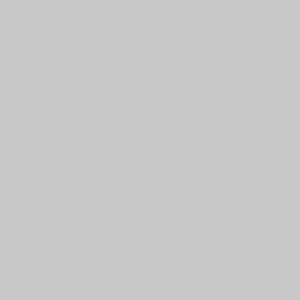

In [45]:
im = Image.fromarray(np.uint8(mask))
im.show()

In [1]:
from diffusers import DDIMScheduler, StableDiffusionInpaintPipeline
import torch

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


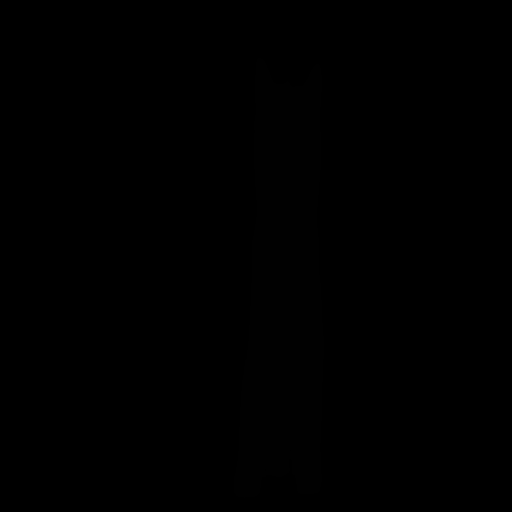

In [47]:
img = Image.open("/home/docker_current/samfusion/mask.png")
img.show()

In [52]:
np.array(img).shape

(512, 512)

In [51]:
np.unique(np.array(img))

array([0, 1], dtype=uint8)

In [ ]:
np.

In [2]:
device = "cuda"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    requires_safety_checker=False,
    safety_checker=None,
    revision="fp16",
    torch_dtype=torch.float16,
).to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

vae/diffusion_pytorch_model.safetensors not found





Fetching 13 files:  31%|███       | 4/13 [00:00<00:01,  5.13it/s]










Fetching 13 files:  31%|███       | 4/13 [00:16<00:01,  5.13it/s]






























































Fetching 13 files: 100%|██████████| 13/13 [10:12<00:00, 47.11s/it]
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|█████

In [1]:
# %load_ext gradio

In [2]:
import cv2
import gradio as gr
import numpy as np
import torch
from segment_anything import SamPredictor, sam_model_registry

MODEL_DICT = dict(
    vit_h='https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth',  # yapf: disable  # noqa
    vit_l='https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth',  # yapf: disable  # noqa
    vit_b='https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth',  # yapf: disable  # noqa
)


def show_mask(mask: np.ndarray,
              image: np.ndarray,
              random_color: bool = False) -> np.ndarray:
    """Visualize a mask on top of an image.

    Args:
        mask (np.ndarray): A 2D array of shape (H, W).
        image (np.ndarray): A 3D array of shape (H, W, 3).
        random_color (bool): Whether to use a random color for the mask.
    Returns:
        np.ndarray: A 3D array of shape (H, W, 3) with the mask
        visualized on top of the image.
    """
    if random_color:
        color = np.concatenate([np.random.random(3)], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1) * 255

    image = cv2.addWeighted(image, 0.7, mask_image.astype('uint8'), 0.3, 0)
    return image


def show_points(coords: np.ndarray, labels: np.ndarray,
                image: np.ndarray) -> np.ndarray:
    """Visualize points on top of an image.

    Args:
        coords (np.ndarray): A 2D array of shape (N, 2).
        labels (np.ndarray): A 1D array of shape (N,).
        image (np.ndarray): A 3D array of shape (H, W, 3).
    Returns:
        np.ndarray: A 3D array of shape (H, W, 3) with the points
        visualized on top of the image.
    """
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    for p in pos_points:
        image = cv2.circle(
            image, p.astype(int), radius=5, color=(0, 255, 0), thickness=-1)
    for p in neg_points:
        image = cv2.circle(
            image, p.astype(int), radius=5, color=(255, 0, 0), thickness=-1)
    return image


def setup_model() -> SamPredictor:
    """Setup the model and predictor.

    Returns:
        SamPredictor: The predictor.
    """

    model_type = 'vit_b'
    device = 'cuda'

    sam = sam_model_registry[model_type]()
    sam.load_state_dict(torch.utils.model_zoo.load_url(MODEL_DICT[model_type]))
    sam.half()
    sam.to(device=device)

    predictor = SamPredictor(sam)

    return predictor

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
predictor = setup_model()

In [4]:
# %%blocks

with gr.Blocks() as demo:

    # Define the UI
    mask_level = gr.Slider(minimum=0, maximum=2, value=1, step=1,\
                           label='Masking level',
                           info='(Whole - Part - Subpart) level')
    # with gr.Row():
    input_img = gr.Image(label='Input')
    output_img = gr.Image(label='Selected Segment')

    is_positive_box = gr.Checkbox(value=True, label='Positive point')
    reset = gr.Button('Reset Points')

    # Define the logic
    saved_points = []
    saved_labels = []

    def set_image(img) -> None:
        """Set the image for the predictor."""
        with torch.cuda.amp.autocast():
            predictor.set_image(img)

    def segment_anything(img, mask_level: int, is_positive: bool,
                         evt: gr.SelectData):
        """Segment the selected region."""
        mask_level = 2 - mask_level
        saved_points.append([evt.index[0], evt.index[1]])
        saved_labels.append(1 if is_positive else 0)
        input_point = np.array(saved_points)
        input_label = np.array(saved_labels)

        # Predict the mask
        with torch.cuda.amp.autocast():
            masks, scores, logits = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=True,
            )
        # mask has a shape of [3, h, w]
        masks = masks[mask_level:mask_level + 1, ...]

        # Visualize the mask
        res = show_mask(masks, img)
        # Visualize the points
        res = show_points(input_point, input_label, res)
        return res

    def reset_points() -> None:
        """Reset the points."""
        global saved_points
        global saved_labels
        saved_points = []
        saved_labels = []

    # Connect the UI and logic
    input_img.upload(set_image, [input_img])
    input_img.select(segment_anything,
                     [input_img, mask_level, is_positive_box], output_img)
    reset.click(reset_points)

if __name__ == '__main__':
    demo.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
